# **TimesFM - Google's Foundational Model for Time Series Forecasting**

### Reading The Data
Upload the kaggle dataset inside the colab content to use it.

https://www.kaggle.com/datasets/odins0n/monthly-gold-prices

In [29]:
import pandas as pd
df = pd.read_csv("/content/1979-2021.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').resample('MS').mean()
df = df.reset_index() # Reset index to have 'Date' as a column again
print(df.head())

        Date  United States(USD)  Europe(EUR)  Japan(JPY)  \
0 1979-01-01               233.7        144.8     45160.3   
1 1979-02-01               251.3        154.6     50209.1   
2 1979-03-01               240.1        148.0     50274.3   
3 1979-04-01               245.3        152.8     54144.6   
4 1979-05-01               274.6        172.0     61057.1   

   United Kingdom(GBP)  Canada(CAD)  Switzerland(CHF)  India(INR)  China(CNY)  \
0                117.4        267.1             379.3      1840.8         NaN   
1                124.2        295.5             413.6      2011.7         NaN   
2                116.2        278.2             406.2      1940.2         NaN   
3                118.8        278.5             420.0      2013.1         NaN   
4                132.7        321.6             478.0      2253.4         NaN   

   Turkey(TRY)  Saudi Arabia(SAR)  Indonesia(IDR)  United Arab Emirates(AED)  \
0          NaN              745.2        139739.3                 

/tmp/ipython-input-4293038334.py:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


### Visualise the Dataset

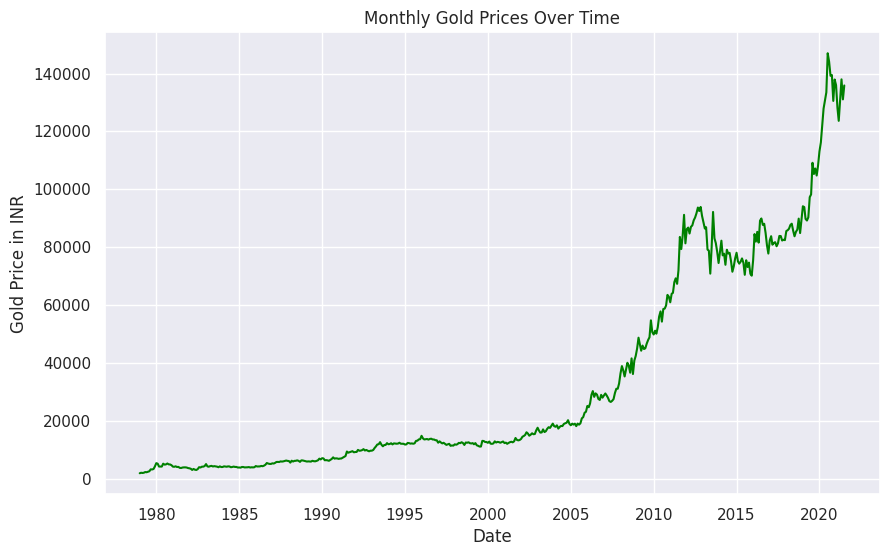

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="Date", y='India(INR)', data=df, color='green')
plt.title('Monthly Gold Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Gold Price in INR')
plt.show()

### Time-series decomposition visualization - trend, seasonality and residuals

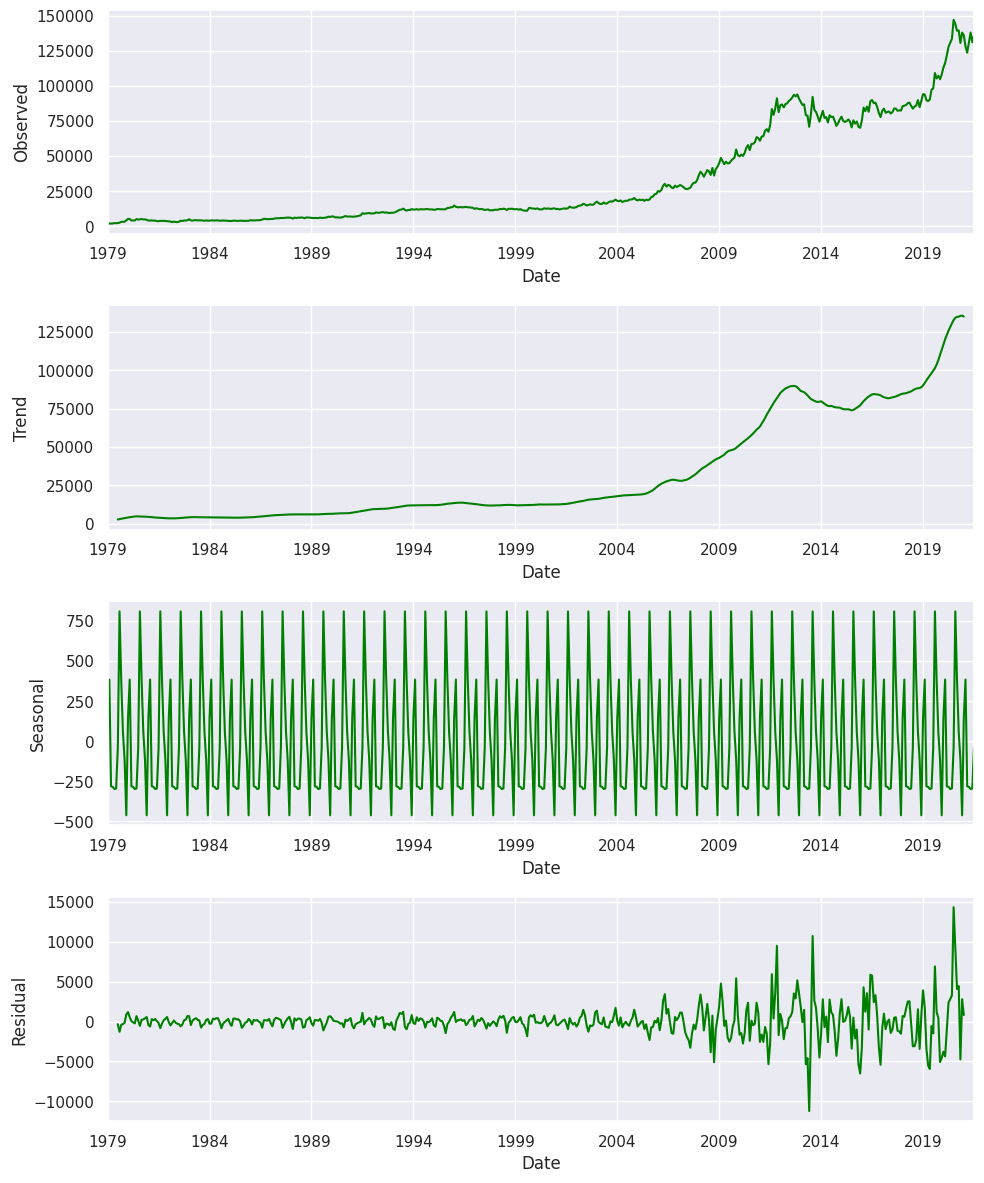

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

df.set_index("Date", inplace=True)
result = seasonal_decompose(df['India(INR)'])
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))
result.observed.plot(ax=ax1, color='green')
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2, color='green')
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3, color='green')
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4, color='green')
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()
df.reset_index(inplace=True)

### Arranging the Data in Format as Required by the Models

In [13]:
df = pd.DataFrame({'unique_id':[1]*len(df),'ds': df["Date"], "y":df['India(INR)']})
train_df = df[df['ds'] <= '31-07-2019']
test_df = df[df['ds'] > '31-07-2019']

## Statistical Modeling

### Installing the dependencies

In [14]:
!pip install statsforecast

### Perform forecasting using AutoARIMA and AutoETS

In [15]:
import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS

# Define the AutoARIMA model
autoarima = AutoARIMA(season_length=12)
# Define the AutoETS model
autoets = AutoETS(season_length=12)

# Create StatsForecast object with AutoARIMA
statforecast = StatsForecast(
    models=[autoarima, autoets],
    freq='MS',
    n_jobs=-1)
statforecast.fit(train_df)

# Generate forecasts for 24 periods ahead
sf_forecast = statforecast.forecast(df=train_df, h=24, fitted=True)
sf_forecast = sf_forecast.reset_index()
print("StatsForecast:", sf_forecast)

StatsForecast:     index  unique_id         ds      AutoARIMA        AutoETS
0       0          1 2019-08-01   98004.546806   98347.268358
1       1          1 2019-09-01   97881.784289   98594.931527
2       2          1 2019-10-01   97867.783054   98837.628860
3       3          1 2019-11-01   98727.726760   99075.459924
4       4          1 2019-12-01   99166.750624   99308.522294
5       5          1 2020-01-01  100363.736924   99536.911584
6       6          1 2020-02-01  100585.275690   99760.721494
7       7          1 2020-03-01  100670.584649   99980.043843
8       8          1 2020-04-01  101327.335216  100194.968611
9       9          1 2020-05-01  101721.665007  100405.583973
10     10          1 2020-06-01  101634.099419  100611.976335
11     11          1 2020-07-01  101333.096138  100814.230372
12     12          1 2020-08-01  101969.209148  101012.429060
13     13          1 2020-09-01  102403.455399  101206.653713
14     14          1 2020-10-01  103691.298539  101396.

## MLForecast

### Installing the dependencies

In [16]:
!pip install mlforecast

### Perform forecasting using XGBoost

In [17]:
from mlforecast import MLForecast
from mlforecast.target_transforms import AutoDifferences
from numba import njit
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from mlforecast import MLForecast
from mlforecast.lag_transforms import (
 RollingMean, RollingStd, RollingMin, RollingMax, RollingQuantile,
 SeasonalRollingMean, SeasonalRollingStd, SeasonalRollingMin,
 SeasonalRollingMax, SeasonalRollingQuantile,
 ExpandingMean
)

models = [lgb.LGBMRegressor(verbosity=-1),
 xgb.XGBRegressor(),
 RandomForestRegressor(random_state=0),
]
fcst = MLForecast(
    models=models, # List of models to be used for forecasting
    freq='MS', # Monthly frequency, starting at the beginning of each month
    lags=[1,3,5,7,12], # Lag features: values from 1, 3, 5, 7, and 12 time steps ago
    lag_transforms={
        1: [ # Transformations applied to lag 1
            RollingMean(window_size=3),
            RollingStd(window_size=3),
            RollingMin(window_size=3),
            RollingMax(window_size=3),
            RollingQuantile(p=0.5, window_size=3),
            ExpandingMean()
        ],
        6:[ # Transformations applied to lag 6
            RollingMean(window_size=6),
            RollingStd(window_size=6),
            RollingMin(window_size=6),
            RollingMax(window_size=6),
            RollingQuantile(p=0.5, window_size=6),
        ],
        12: [ # Transformations applied to lag 12 (likely for yearly seasonality)
            SeasonalRollingMean(season_length=12, window_size=3),
            SeasonalRollingStd(season_length=12, window_size=3),
            SeasonalRollingMin(season_length=12, window_size=3),
            SeasonalRollingMax(season_length=12, window_size=3),
            SeasonalRollingQuantile(p=0.5, season_length=12, window_size=3)
        ]
    },
    date_features=['year', 'month', 'quarter'], # Extract year, month, and quarter from the date as features
    target_transforms=[AutoDifferences(max_diffs=3)]
)

fcst.fit(train_df)
ml_forecast = fcst.predict(len(test_df))
print("MLForecast:", ml_forecast)

MLForecast:     unique_id         ds  LGBMRegressor   XGBRegressor  RandomForestRegressor
0           1 2019-08-01  100627.541043   99412.076459             100065.030
1           1 2019-09-01  104693.185513  101027.233545              99801.598
2           1 2019-10-01  104872.905318   99663.670416             100974.764
3           1 2019-11-01  102817.457246   99590.707751             101976.430
4           1 2019-12-01  103643.384884   99945.998413             103965.846
5           1 2020-01-01  105130.781116  100566.706769             104792.933
6           1 2020-02-01  106353.689009  102407.216028             105725.559
7           1 2020-03-01  105995.845434  102589.615302             106914.900
8           1 2020-04-01  105753.028265  102092.625049             108771.279
9           1 2020-05-01  105242.190622  102405.231781             109556.995
10          1 2020-06-01  104955.837859  102811.125104             110530.202
11          1 2020-07-01  104819.483689  102793.8976

## TimeGPT

### Installing the dependencies

In [18]:
!pip install nixtla

### Perform forecasting using TimeGPT

In [19]:
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(api_key = 'nixak-PJPGa3MxJ3VdxZhKvylOcu2XHBtZ8ssIykc7wzoLKB0sVcDMnHoD53kGpvuJGk9e5lj83KojwKaljmcK')
timegpt_forecast = nixtla_client.forecast(df=train_df, h=24, freq='MS')
print("TimeGPT: ", timegpt_forecast)

TimeGPT:      unique_id         ds    TimeGPT
0           1 2019-08-01  96605.984
1           1 2019-09-01  95637.090
2           1 2019-10-01  95362.930
3           1 2019-11-01  94335.390
4           1 2019-12-01  94808.945
5           1 2020-01-01  95810.800
6           1 2020-02-01  95926.890
7           1 2020-03-01  95180.580
8           1 2020-04-01  94824.420
9           1 2020-05-01  95190.000
10          1 2020-06-01  95458.805
11          1 2020-07-01  94753.000
12          1 2020-08-01  94876.390
13          1 2020-09-01  94924.250
14          1 2020-10-01  95532.400
15          1 2020-11-01  94622.580
16          1 2020-12-01  95475.300
17          1 2021-01-01  95592.070
18          1 2021-02-01  95540.130
19          1 2021-03-01  95010.080
20          1 2021-04-01  94569.720
21          1 2021-05-01  94928.836
22          1 2021-06-01  95347.805
23          1 2021-07-01  95041.300


## TimesFM

### Installing the dependencies

In [4]:
!git clone https://github.com/google-research/timesfm.git

fatal: destination path 'timesfm' already exists and is not an empty directory.


In [5]:
%cd /content/timesfm

/content/timesfm


In [6]:
!uv pip install -e .[torch]

Using Python 3.12.12 environment at: /usr
Resolved 42 packages in 49ms
Prepared 1 package in 715ms
Installed 1 package in 0.90ms
 + timesfm==2.0.0 (from file:///content/timesfm)


In [24]:
%cd ..

/content


In [25]:
import torch
import numpy as np
import pandas as pd
import timesfm

torch.set_float32_matmul_precision("high")
model = timesfm.TimesFM_2p5_200M_torch.from_pretrained("google/timesfm-2.5-200m-pytorch")

model.compile(
    timesfm.ForecastConfig(
        max_context=1024,                # Maximum context length
        max_horizon=256,                 # Maximum forecast horizon
        normalize_inputs=True,           # Normalize time series before forecasting
        use_continuous_quantile_head=True,
        force_flip_invariance=True,
        infer_is_positive=True,
        fix_quantile_crossing=True,
    )
)
H = 24  # Forecast horizon

series_list = []
for _, g in train_df.groupby("unique_id"):
    series_list.append(g["y"].values.astype(np.float32))

point_forecast, quantile_forecast = model.forecast(
    horizon=H,
    inputs=series_list,
)

forecasts = []
for (uid, group), preds in zip(train_df.groupby("unique_id"), point_forecast):
    # Get last date and extend future timestamps
    last_date = group["ds"].iloc[-1]
    future_dates = pd.date_range(start=last_date, periods=H + 1, freq="MS")[1:]
    df_pred = pd.DataFrame({
        "unique_id": uid,
        "ds": future_dates,
        "timesfm": preds
    })
    forecasts.append(df_pred)

timesfm_forecast = pd.concat(forecasts, ignore_index=True)
print("TimesEM: ", timesfm_forecast)

TimesEM:      unique_id         ds       timesfm
0           1 2019-08-01  96371.273438
1           1 2019-09-01  95893.062500
2           1 2019-10-01  96230.250000
3           1 2019-11-01  96246.000000
4           1 2019-12-01  96163.367188
5           1 2020-01-01  96386.156250
6           1 2020-02-01  97181.156250
7           1 2020-03-01  96687.703125
8           1 2020-04-01  97069.351562
9           1 2020-05-01  97310.554688
10          1 2020-06-01  97717.226562
11          1 2020-07-01  97986.906250
12          1 2020-08-01  98102.125000
13          1 2020-09-01  97577.195312
14          1 2020-10-01  98056.460938
15          1 2020-11-01  97912.945312
16          1 2020-12-01  97729.265625
17          1 2021-01-01  97603.945312
18          1 2021-02-01  97536.328125
19          1 2021-03-01  97192.867188
20          1 2021-04-01  97171.875000
21          1 2021-05-01  96019.117188
22          1 2021-06-01  96458.187500
23          1 2021-07-01  96719.382812


### Convert 'ds' to datetime in all DataFrames if necessary

In [21]:
# Assuming the DataFrames have a common column 'ds' for the dates
sf_forecast['ds'] = pd.to_datetime(sf_forecast['ds'])
ml_forecast['ds'] = pd.to_datetime(ml_forecast['ds'])
timegpt_forecast['ds'] = pd.to_datetime(timegpt_forecast['ds'])
timesfm_forecast['ds'] = pd.to_datetime(timesfm_forecast['ds'])
test_df['ds'] = pd.to_datetime(test_df['ds'])

# Print shapes to debug
print("sf_forecast shape:", sf_forecast.shape)
print("ml_forecast shape:", ml_forecast.shape)
print("timegpt_forecast shape:", timegpt_forecast.shape)
print("timesfm_forecast shape:", timesfm_forecast.shape)
print("test_df shape:", test_df.shape)

# Check the first few dates
print("\nFirst dates:")
print("sf_forecast:", sf_forecast['ds'].head(3).tolist())
print("ml_forecast:", ml_forecast['ds'].head(3).tolist())
print("test_df:", test_df['ds'].head(3).tolist())


sf_forecast shape: (24, 5)
ml_forecast shape: (24, 5)
timegpt_forecast shape: (24, 3)
timesfm_forecast shape: (24, 3)
test_df shape: (24, 3)

First dates:
sf_forecast: [Timestamp('2019-08-01 00:00:00'), Timestamp('2019-09-01 00:00:00'), Timestamp('2019-10-01 00:00:00')]
ml_forecast: [Timestamp('2019-08-01 00:00:00'), Timestamp('2019-09-01 00:00:00'), Timestamp('2019-10-01 00:00:00')]
test_df: [Timestamp('2019-08-01 00:00:00'), Timestamp('2019-09-01 00:00:00'), Timestamp('2019-10-01 00:00:00')]


/tmp/ipython-input-2137114286.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['ds'] = pd.to_datetime(test_df['ds'])


### Perform the merges - start with test_df to ensure we keep all test dates

In [22]:
merged_fcst = test_df[['ds', 'y', 'unique_id']].copy()
merged_fcst = pd.merge(merged_fcst, sf_forecast[['ds', 'AutoARIMA', 'AutoETS']], on='ds', how='left')
merged_fcst = pd.merge(merged_fcst, ml_forecast[['ds', 'LGBMRegressor', 'XGBRegressor', 'RandomForestRegressor']], on='ds', how='left')
merged_fcst = pd.merge(merged_fcst, timegpt_forecast[['ds', 'TimeGPT']], on='ds', how='left')
merged_fcst = pd.merge(merged_fcst, timesfm_forecast[['ds', 'timesfm']], on='ds', how='left')

print("\nMerged forecast shape:", merged_fcst.shape)
print("\nMerged forecast columns:", merged_fcst.columns.tolist())
print("\nFirst few rows of merged_fcst:")
print(merged_fcst.head())
print("\nNull counts:")
print(merged_fcst.isnull().sum())


Merged forecast shape: (24, 10)

Merged forecast columns: ['ds', 'y', 'unique_id', 'AutoARIMA', 'AutoETS', 'LGBMRegressor', 'XGBRegressor', 'RandomForestRegressor', 'TimeGPT', 'timesfm']

First few rows of merged_fcst:
          ds         y  unique_id     AutoARIMA       AutoETS  LGBMRegressor  \
0 2019-08-01  109139.2          1  98004.546806  98347.268358  100627.541043   
1 2019-09-01  105261.4          1  97881.784289  98594.931527  104693.185513   
2 2019-10-01  107169.8          1  97867.783054  98837.628860  104872.905318   
3 2019-11-01  104747.5          1  98727.726760  99075.459924  102817.457246   
4 2019-12-01  108120.0          1  99166.750624  99308.522294  103643.384884   

    XGBRegressor  RandomForestRegressor    TimeGPT       timesfm  
0   99412.076459             100065.030  96605.984  96371.273438  
1  101027.233545              99801.598  95637.090  95893.062500  
2   99663.670416             100974.764  95362.930  96230.250000  
3   99590.707751             10

In [26]:
merged_fcst.to_csv("TimesFM_Forecast_Comparison.csv")

## Evaluation of the Models

In [27]:
import numpy as np

def calculate_error_metrics(actual_values, predicted_values):
    actual_values = np.array(actual_values)
    predicted_values = np.array(predicted_values)

    # Remove any NaN values
    mask = ~(np.isnan(actual_values) | np.isnan(predicted_values))
    actual_values = actual_values[mask]
    predicted_values = predicted_values[mask]

    if len(actual_values) == 0:
        print(f"Warning: No valid data points after removing NaNs")
        return pd.DataFrame({'Metric': ['MAE', 'RMSE', 'MAPE'], 'Value': [np.nan, np.nan, np.nan]})

    metrics_dict = {
        'MAE': np.mean(np.abs(actual_values - predicted_values)),
        'RMSE': np.sqrt(np.mean((actual_values - predicted_values)**2)),
        'MAPE': np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    }

    result_df = pd.DataFrame(list(metrics_dict.items()), columns=['Metric', 'Value'])
    return result_df

# Use actual gold prices from merged dataframe
actuals = merged_fcst['y'].values
error_metrics_dict = {}

# Model columns to evaluate
model_columns = ['AutoARIMA', 'AutoETS', 'LGBMRegressor', 'XGBRegressor', 'RandomForestRegressor', 'TimeGPT', 'timesfm']

for col in model_columns:
    if col in merged_fcst.columns:
        print(f"\nEvaluating {col}...")
        predicted_values = merged_fcst[col].values
        print(f"  Actuals shape: {actuals.shape}, Predictions shape: {predicted_values.shape}")
        print(f"  Non-null predictions: {(~np.isnan(predicted_values)).sum()}")
        error_metrics_dict[col] = calculate_error_metrics(actuals, predicted_values)['Value'].values
    else:
        print(f"\nWarning: {col} not found in merged_fcst")

error_metrics_df = pd.DataFrame(error_metrics_dict)
error_metrics_df.insert(0, 'Metric', ['MAE', 'RMSE', 'MAPE'])

print("\n" + "="*80)
print("FINAL ERROR METRICS:")
print("="*80)
print(error_metrics_df)


Evaluating AutoARIMA...
  Actuals shape: (24,), Predictions shape: (24,)
  Non-null predictions: 24

Evaluating AutoETS...
  Actuals shape: (24,), Predictions shape: (24,)
  Non-null predictions: 24

Evaluating LGBMRegressor...
  Actuals shape: (24,), Predictions shape: (24,)
  Non-null predictions: 24

Evaluating XGBRegressor...
  Actuals shape: (24,), Predictions shape: (24,)
  Non-null predictions: 24

Evaluating RandomForestRegressor...
  Actuals shape: (24,), Predictions shape: (24,)
  Non-null predictions: 24

Evaluating TimeGPT...
  Actuals shape: (24,), Predictions shape: (24,)
  Non-null predictions: 24

Evaluating timesfm...
  Actuals shape: (24,), Predictions shape: (24,)
  Non-null predictions: 24

FINAL ERROR METRICS:
  Metric     AutoARIMA       AutoETS  LGBMRegressor  XGBRegressor  \
0    MAE  24280.729338  25815.570594   26114.692951  26307.765639   
1   RMSE  26638.214297  28348.635505   30270.595340  29209.266915   
2   MAPE     18.483418     19.624235      19.622936